In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [39]:

# Load the data
data = pd.read_csv('microsoftdata.csv')
#data = pd.read_csv('Tesla_Stock_Updated_V2_2.csv') 
#data = pd.read_csv('goldstock_2.csv') 
data = data.rename(columns={'Close(t)':'Close'})

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,03/01/2022,335.350006,338.000000,329.779999,334.750000,328.120880,28865100
1,04/01/2022,334.829987,335.200012,326.119995,329.010010,322.494568,32674300
2,05/01/2022,325.859985,326.070007,315.980011,316.380005,310.114654,40054300
3,06/01/2022,313.149994,318.700012,311.489990,313.880005,307.664154,39646100
4,07/01/2022,314.149994,316.500000,310.089996,314.040008,307.820984,32720000


In [40]:

# Calculate technical indicators
data['50_MA'] = data['Close'].rolling(window=50).mean()
data['20_STD'] = data['Close'].rolling(window=20).std()
data['Upper_Band'] = data['Close'] + 2 * data['20_STD']
data['Lower_Band'] = data['Close'] - 2 * data['20_STD']

# Calculate previous low and high
data['Prev_Low'] = data['Low'].shift(+1)
data['Prev_High'] = data['High'].shift(+1)

# Generate buy and sell signals using Aroon
data['aroon_bull'] = 100 * data['High'].rolling(window=14).apply(lambda x: x.argmax()) / 14
data['aroon_bear'] = 100 * data['Low'].rolling(window=14).apply(lambda x: x.argmin()) / 14

#data['Buy_Signal'] = np.where((data['Close'] > data['50_MA']) & (data['aroon_bull'] > data['aroon_bear']), 1, 0)
#data['Sell_Signal'] = np.where((data['Close'] < data['50_MA']) & (data['aroon_bear'] > data['aroon_bull']), -1, 0)

data['Buy_Signal'] = np.where((data['aroon_bull'] > data['aroon_bear']), 1, 0)
data['Sell_Signal'] = np.where((data['aroon_bear'] > data['aroon_bull']), -1, 0)

In [41]:

# Prepare the data for analysis
#data['Tomorrows Close'] = data['Close'].shift(-1)
data = data.dropna()


In [42]:
def trading_strategy(data):
    signals = []
    positions = []
    current_position = 0

    for i in range(len(data)):
        if i < len(data['Buy_Signal']) and i < len(data['Sell_Signal']):
            if data['Buy_Signal'].iloc[i] == 1 and current_position == 0:
                signals.append(1)
                current_position = 1
                positions.append(current_position)
            elif data['Sell_Signal'].iloc[i] == -1 and current_position == 1:
                signals.append(-1)
                current_position = 0
                positions.append(current_position)
            else:
                signals.append(0)
                positions.append(current_position)
        else:
            signals.append(0)
            positions.append(current_position)

    return signals[:len(data)], positions[:len(data)]

In [43]:
data.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,50_MA,20_STD,Upper_Band,Lower_Band,Prev_Low,Prev_High,aroon_bull,aroon_bear,Buy_Signal,Sell_Signal
496,22/12/2023,373.679993,375.179993,372.709992,374.579987,373.888580,17091100,360.019802,3.975803,382.531594,366.628380,370.040008,374.410004,42.857143,50.000000,0,-1
497,26/12/2023,375.000000,376.940002,373.500000,374.660004,373.968445,12673100,360.958402,3.804540,382.269083,367.050925,372.709992,375.179993,35.714286,42.857143,0,-1
498,27/12/2023,373.690002,375.059998,372.809998,374.070007,373.379547,14905400,361.787002,3.112525,380.295058,367.844957,373.500000,376.940002,28.571429,35.714286,0,-1
499,28/12/2023,375.369995,376.459992,374.160004,375.279999,374.587280,14327000,362.651402,2.844136,380.968270,369.591728,372.809998,375.059998,21.428571,28.571429,0,-1
500,29/12/2023,376.000000,377.160004,373.480011,376.040008,375.345886,18723000,363.570002,2.575146,381.190300,370.889717,374.160004,376.459992,14.285714,21.428571,0,-1


In [44]:
#data['Buy_Signal']

In [45]:
#data['Sell_Signal']

In [46]:
# Apply the trading strategy
signals, positions = trading_strategy(data)
data['Signals'] = signals
data['Positions'] = positions


In [47]:

# Calculate the returns
data['Returns'] = data['Close'].pct_change()
data['Strategy_Returns'] = data['Positions'].shift(1) * data['Returns']

# Evaluate the strategy
print("Total Returns:", data['Strategy_Returns'].sum())
print("Annualized Returns:", (1 + data['Strategy_Returns'].sum()) ** (252 / len(data)) - 1)

Total Returns: 0.15793300934552235
Annualized Returns: 0.08518785262819151


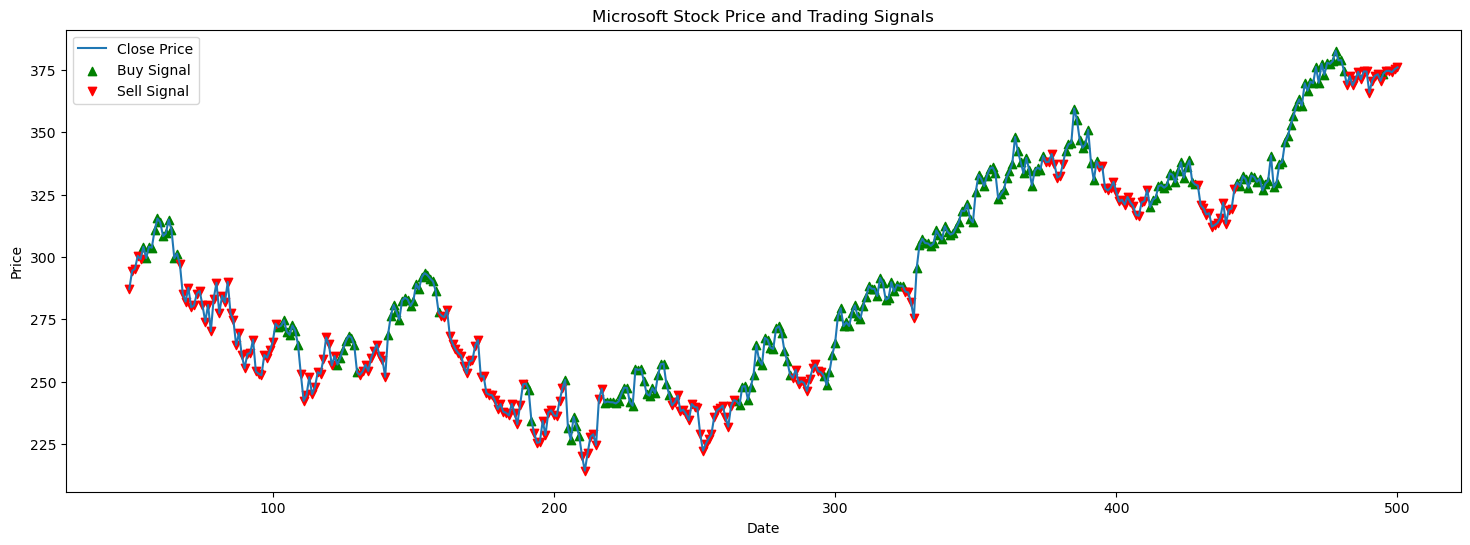

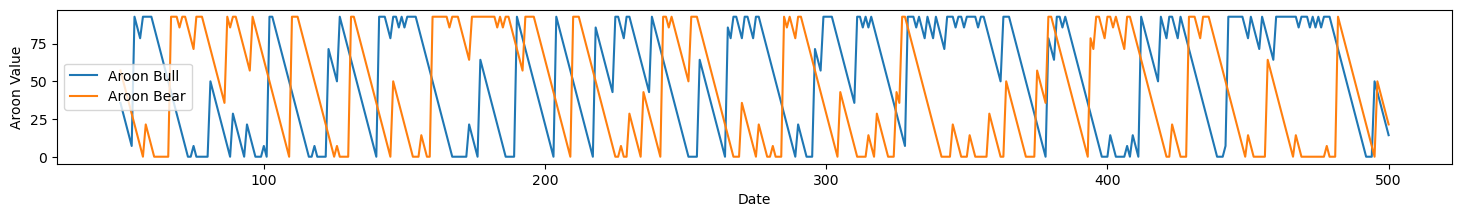

In [48]:
# Plot the signals
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the close price and buy/sell signals
ax1.plot(data.index, data['Close'], label='Close Price')
ax1.scatter(data.index[data['Buy_Signal'] == 1], data['Close'][data['Buy_Signal'] == 1], color='green', marker='^', label='Buy Signal')
ax1.scatter(data.index[data['Sell_Signal'] == -1], data['Close'][data['Sell_Signal'] == -1], color='red', marker='v', label='Sell Signal')
ax1.set_title('Microsoft Stock Price and Trading Signals')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
plt.show()

# Plot the Aroon bull and bear indicators
fig, ax2 = plt.subplots(figsize=(18, 2))
ax2.plot(data.index, data['aroon_bull'], label='Aroon Bull')
ax2.plot(data.index, data['aroon_bear'], label='Aroon Bear')
ax2.set_xlabel('Date')
ax2.set_ylabel('Aroon Value')
ax2.legend()
#plt.tight_layout()
plt.show()

In [49]:
# Calculate the actual stock returns
actual_returns = data['Close'].pct_change().fillna(0)

# Calculate the simulated portfolio value
portfolio_value = [1000]  # Starting portfolio value
for i in range(1, len(data)):
    if i < len(positions) and i < len(data):
        if positions[i-1] == 0 and positions[i] == 1:
            portfolio_value.append(portfolio_value[-1] * (data['Close'].iloc[i] / data['Close'].iloc[i-1]))
        elif positions[i-1] == 1 and positions[i] == -1:
            portfolio_value.append(portfolio_value[-1] * (data['Close'].iloc[i] / data['Close'].iloc[i-1]))
        elif positions[i-1] == -1 and positions[i] == 0:
            portfolio_value.append(portfolio_value[-1] * (data['Close'].iloc[i] / data['Close'].iloc[i-1]))
        else:
            portfolio_value.append(portfolio_value[-1])
    else:
        portfolio_value.append(portfolio_value[-1])

In [50]:
# Calculate the portfolio returns
portfolio_returns = np.array(portfolio_value[1:]) / np.array(portfolio_value[:-1]) - 1

# Ensure all arrays have the same length
actual_returns = actual_returns[:len(portfolio_returns)]
portfolio_returns = portfolio_returns[:len(actual_returns)]

# Calculate the evaluation metrics
mse = mean_squared_error(actual_returns, portfolio_returns)
rmse = np.sqrt(mse)
r2 = r2_score(actual_returns, portfolio_returns)
mae = mean_absolute_error(actual_returns, portfolio_returns)

print("_")
print("Test MSE:", mse)
print("_")
print("RMSE:", rmse)
print("_")
print("R-squared:", r2)
print("_")
print("MAE:", mae)
print("_")

_
Test MSE: 0.0004063418845622386
_
RMSE: 0.020157923617333175
_
R-squared: -0.12023615424758005
_
MAE: 0.014773524579193282
_
